In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, lil_matrix, kron
from scipy.linalg import sqrtm
from scipy.special import gamma, factorial, legendre, lpmv, lpmn

In [2]:
def sample_fBm(n, H):
    s, k = np.zeros(2*(n-1)), np.linspace(0, 2*(n-1)-1, 2*(n-1))
    s = (abs((k-1)/n)**(2*H) - 2*(k/n)**(2*H) + ((k+1)/n)**(2*H))/2
    S = np.concatenate((s[0:(n-1)], s[n-1], s[(n-2):0:-1]), axis=None)
    S_tilde = np.fft.fft(S)
    
    x_1, x_2 = np.random.normal(0, 1, 2*(n-1)), np.random.normal(0, 1, 2*(n-1))
    x = [ np.complex(x_1[i], x_2[i]) for i in range(0, 2*(n-1)) ] 
    y = np.fft.fft(np.sqrt(S_tilde)*x)
    y1 = (1/np.sqrt(2*(n-1)))*y.real
    Y1 = np.zeros(n+1)
    Y1[0], Y1[1:(n+2)] = 0, np.cumsum(y1[0:n])
    return Y1

def sample_one_oov(n, beta):
    ## generate the random parameter Lambda first.
    ga_1, ga_beta, ga_1beta = np.random.gamma(1, 1), np.random.gamma(beta, 1), np.random.gamma(1-beta, 1)
    Lambda = ga_1*ga_1beta/ga_beta

    t = np.linspace(0, 1, n+1)
    uu = np.random.uniform(0, 1)
    ind1 = np.where(t<uu, 0, 1)
    proba = 0.5*(1-np.exp(-2*(1/n)*Lambda))
    ind2 = np.random.binomial(1, proba, n+1)
    return (ind1+ind2.cumsum()) % 2


def R1_large_jump(N, n, alpha, beta, epsilon):
    ## sampling N iid layers
    D = np.zeros((n+1, N))
    for i in range(0,N):
        D[:,i] = sample_one_oov(n, beta)

    U = np.random.uniform(0, 1, N)
    V = np.random.choice([-1, 1], N, replace=True, p=[0.5, 0.5])*(epsilon/(U**(1/alpha))) 
    return np.sum(D*V, axis=1)
        
def R1_KSP(n, alpha, beta):
    if alpha == 1:
        C_alpha = np.pi/2
    else:
        C_alpha = (1-alpha)/(gamma(2-alpha)*np.cos(np.pi*alpha/2))
    if alpha >= 1:
        epsilon = (0.01*(3-alpha)*np.sqrt(alpha*C_alpha)/(2-alpha)**(3/2))**(2/alpha)     # error from B-E < 0.01
    else:
        epsilon = 0.0001
    sigma_epsilon = (np.sqrt(alpha*C_alpha/(2-alpha))**(1/2))*epsilon**(1-alpha/2)
    nu_epsilon = 2**(1-beta)*C_alpha*epsilon**(-alpha)
    N = int(np.random.poisson(nu_epsilon, 1))
    
    Y1 = sigma_epsilon*sample_fBm(n, beta/2)
    Y2 = R1_large_jump(N, n, alpha, beta, epsilon=epsilon)
    return Y1, Y2, Y1+Y2

In [3]:
import numpy as np
import pandas as pd
from scipy.special import gamma, factorial

def rho(c0, c2, x, y, H):
    h = np.sqrt((x[0]-y[0])**2 + (x[1]-y[1])**2)
    cov = c0 + c2*h**2 - h**(2*H)
    return cov

def R2_fft(n, H):
    t1, t2 = np.linspace(0, 1/np.sqrt(2), n+1), np.linspace(0, 1/np.sqrt(2), n+1)
    c2 = H
    c0 = 1 - c2
    cov = np.zeros((n+1, n+1))
    for i in range(0, n+1):
        for j in range(0, n+1):
            cov[j, i] = rho(c0, c2, [t1[i], t2[j]], [t1[0], t2[0]], H)
    s, S = np.zeros((2*n, 2*n)), np.zeros((2*n, 2*n))
    s[0:(n+1),:] = np.c_[cov[:,0:n], cov[:,n], cov[:,n-1:0:-1]]
    S = np.r_[s[0:n,:], s[n,:].reshape(1, 2*n), s[n-1:0:-1,:]]
    S_tilde = np.fft.fft2(S)
    return c0, c2, S_tilde

def LC_complex_rv(n):
    x_1, x_2 = np.random.multivariate_normal(np.zeros(2*n), np.diag(np.ones(2*n)), 2*n), np.random.multivariate_normal(np.zeros(2*n), np.diag(np.ones(2*n)), 2*n)
    x = np.zeros((2*n, 2*n), dtype=np.complex)
    for i in range(0, 2*n):
        for j in range(0, 2*n):
            x[i, j] = np.complex(x_1[i,j], x_2[i,j])
    return x

def LC_small_t(n, t1, t2):
    z1, z2 = np.random.normal(0, 1, 1), np.random.normal(0, 1, 1)
    t = np.zeros((n+1, n+1))
    for i in range(0, n+1):
        for j in range(0, n+1):
            t[i,j] = t1[i]*z1 + t2[j]*z2
    return t

def LC_fBm(n, H):
    t1, t2 = np.linspace(0, 1/np.sqrt(2), n+1), np.linspace(0, 1/np.sqrt(2), n+1)
    c0, c2, S_tilde = R2_fft(n, H)
    x = LC_complex_rv(n)
    y = np.fft.fft2(np.sqrt(S_tilde)*x)
    y1_tilde = (1/(2*n))*y.real[0:n+1,0:n+1]
    y1 = np.zeros((n+1, n+1))
    t = LC_small_t(n, t1, t2)
    y1 = y1_tilde - y1_tilde[0,0] + np.sqrt(2*c2)*t
    return np.sqrt(2**((beta/2)-1))*y1

def LC_one_oov(n, beta, flattened = False):
    ga_1, ga_beta, ga_1beta = np.random.gamma(1, 1, 1), np.random.gamma(beta, 1, 1), np.random.gamma(1-beta, 1, 1)
    Lambda = ga_1*ga_1beta/ga_beta
    Q_beta = 1 + np.random.poisson(Lambda, 1)
    if (beta <= 0.5):
        Q_beta[Q_beta > 10000] = 10000
    t1, t2 = np.linspace(0, 1, n+1), np.linspace(0, 1, n+1)
    #t1, t2 = np.linspace(0, 1/np.sqrt(2), n+1), np.linspace(0, 1/np.sqrt(2), n+1)
    t_1, t_2 = np.meshgrid(t1, t2)
    #t_1, t_2 = t_1.flatten(), t_2.flatten()
    r = np.random.uniform(0, np.sqrt(2), int((3/4)*Q_beta))
    #theta = np.random.uniform(0, 2*np.pi, Q_beta)
    theta = np.random.uniform(-np.pi/2, np.pi, int((3/4)*Q_beta))
    s_pos = np.c_[np.cos(theta), np.sin(theta)]
    count = np.zeros((n+1, n+1))
    for i in range(0, int((3/4)*Q_beta)):
        event = np.where(r[i] < s_pos[i,0]*t_1+s_pos[i,1]*t_2, 1, 0)
        count += event
    if flattened == False:
        return count % 2
    else:
        return (count % 2).flatten()

def LC_large_jump(N, n, alpha, beta, epsilon):    
    D = np.zeros(((n+1)**2, N))
    for i in range(0, N):
        D[:, i] = LC_one_oov(n, beta, flattened = True)
    
    U = np.random.uniform(0, 1, N)
    V = np.random.choice([-1, 1], N, replace=True, p=[0.5, 0.5])*(epsilon/(U**(1/alpha)))   
    y2 = np.sum(D*V, axis=1)
    return y2.reshape(n+1, n+1)

def LC_KSP(n, alpha, beta):
    if alpha == 1:
        C_alpha = np.pi/2
    else:
        C_alpha = (1-alpha)/(gamma(2-alpha)*np.cos(np.pi*alpha/2))
    if alpha >= 1:
        epsilon = (0.01*(3-alpha)*np.sqrt(alpha*C_alpha)/(2-alpha)**(3/2))**(2/alpha)     # error from B-E < 0.01
    else:
        epsilon = 0.0001
    sigma_epsilon = (np.sqrt(alpha*C_alpha/(2-alpha))**(1/2))*epsilon**(1-alpha/2)
    nu_epsilon = 2**(1-beta)*(np.sqrt(2)*2*np.pi)**(beta)*C_alpha*epsilon**(-alpha)
    N = int(np.random.poisson(nu_epsilon, 1))  
    
    Y1 = sigma_epsilon*LC_fBm(n, beta/2)
    Y2 = LC_large_jump(N, n, alpha, beta, epsilon=epsilon)
    Y = Y1 + Y2       
    return Y1, Y2, Y

In [4]:
def multi_one_oov(n, beta, flattened = False):
    ga_1, ga_beta, ga_1beta = np.random.gamma(1, 1, 1), np.random.gamma(beta, 1, 1), np.random.gamma(1-beta, 1, 1)
    Lambda = ga_1*ga_1beta/ga_beta
    
    t1, t2 = np.linspace(0, 1, n+1), np.linspace(0, 1, n+1)
    t_1, t_2 = np.meshgrid(t1, t2)
    
    u_x, u_y = np.random.uniform(0, 1, 1), np.random.uniform(0, 1, 1)
    ind1 = np.where((u_x < t_1) & (u_y < t_2), 1, 0)
    
    proba = 0.5*(1-np.exp(-(2/n**2)*Lambda))
    inddd = np.random.binomial(1, proba, (n+1)**2).reshape(n+1, n+1)
    ind2 = inddd.cumsum(axis = 0).cumsum(axis = 1)
    
    if flattened == False:
        return (ind1 + ind2) % 2
    else:
        return ((ind1 + ind2) % 2).flatten()

def multi_fBm(n, H, m = 2500):
    D1 = np.zeros(((n+1)**2, m))
    
    for i in range(0, m):
        D1[:, i] = multi_one_oov(n, 2*H, flattened = True)
    
    e = np.random.normal(0, 1, m)
    return np.sqrt(2**(1-2*H))*(1/np.sqrt(m))*np.sum(D1*e, axis=1).reshape(n+1, n+1)

def multi_large_jump(N, n, alpha, beta, epsilon): 
    D2 = np.zeros(((n+1)**2, N))
    for i in range(0, N):
        D2[:, i] = multi_one_oov(n, beta, flattened = True)
    U = np.random.uniform(0, 1, N)
    V = np.random.choice([-1, 1], N, replace=True, p=[0.5, 0.5])*(epsilon/(U**(1/alpha)))
    return np.sum(D2*V, axis=1).reshape(n+1, n+1)


def multi_KSP(n, alpha, beta, m = 2500):
    if alpha == 1:
        C_alpha = np.pi/2
    else:
        C_alpha = (1-alpha)/(gamma(2-alpha)*np.cos(np.pi*alpha/2))
    if alpha >= 1:
        epsilon = (0.01*(3-alpha)*np.sqrt(alpha*C_alpha)/(2-alpha)**(3/2))**(2/alpha)     # error from B-E < 0.01
    else:
        epsilon = 0.0001
    nu_epsilon = 2**(1-beta)*C_alpha*epsilon**(-alpha)
    N = int(np.random.poisson(nu_epsilon, 1)) 
    sigma_epsilon = (np.sqrt(alpha*C_alpha/(2-alpha))**(1/2))*epsilon**(1-alpha/2) 
    
    Y1 = sigma_epsilon*multi_fBm(n, beta/2, m)
    Y2 = multi_large_jump(N, n, alpha, beta, epsilon=epsilon)
    return Y1, Y2, Y1+Y2


In [5]:
def Sph_vec_coordinates(m, n):
    theta0, phi0 = np.linspace(0, np.pi, m), np.linspace(0, 2*np.pi, n, endpoint=False)
    theta, phi = np.meshgrid(theta0, phi0)
    theta, phi = theta.flatten(), phi.flatten()
    sph_vec = np.zeros((len(theta), 2))
    sph_vec[:,0], sph_vec[:,1] = theta, phi
    return sph_vec

def Sph_cart_coordinates(sph_vec):
    theta, phi = sph_vec[:,0], sph_vec[:,1]
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)
    return x, y, z

def geo_dist(x1, y1, z1, x2, y2, z2):
    geo_d = np.arccos(np.round(x1*x2 + y1*y2 +z1*z2, 15))
    return geo_d

def Sph_cov(x, y, z, H, n, m, c_h):
    cov = np.zeros((m, n*m))
    for i in range(m):
        cov[i, :] = ((2*np.pi)**(2*H))*(1- c_h*(geo_dist(x[i], y[i], z[i], x, y, z))**(2*H))
    return cov

def fourier_mat(n):
    F = np.zeros((n, n), dtype=np.complex)
    for i in range(n):
        for j in range(n):
            F[i, j] = np.exp(-2*np.pi*1j/n)**(i*j)
    return F

def diagonal_lamda(lamda, n, m):
    diag_lamda = lil_matrix((n*m, n*m), dtype=np.complex)
    for i in range(n):
        diag_lamda[(i*m):(i+1)*m, (i*m):(i+1)*m] = sqrtm(lamda[:,(i*m):(i+1)*m])
    return diag_lamda

def Sph_fBm(m, n, H):
    sph_vec = Sph_vec_coordinates(m, n)
    c_h = 0.5*(2/np.pi)**(2*H)
    x, y, z = Sph_cart_coordinates(sph_vec=sph_vec)
    cov = Sph_cov(x, y, z, H, n, m, c_h)
    F = fourier_mat(n)
    F_I = kron(csr_matrix(F), csr_matrix(np.diag(np.ones(m))))
    lamda = csr_matrix(cov).dot(F_I).todense()
    diag_lamda = diagonal_lamda(lamda, n, m)
    Z = np.random.normal(0,1,n*m) + 1j*np.random.normal(0,1,n*m)
    diag_lamda_Z = csr_matrix(diag_lamda).dot(csr_matrix(Z).T)
    X = np.real(F_I.dot(diag_lamda_Z).todense())/np.sqrt(n)
    X1 = np.array(X).reshape(m*n)
    Y1 = (1/4**(2*H))*(X1 - X1[0])
    return Y1, sph_vec

In [6]:
def Sph_counting(XX,YY,ZZ,X,Y,Z):
    count = np.sum((np.outer(X,XX) + np.outer(Y,YY) + np.outer(Z,ZZ)>0), axis = 1)
    return count % 2

def Sph_random_coordinates(n):
    theta = np.arccos(np.random.uniform(-1, 1, n))
    phi = np.random.uniform(0, 2*np.pi, n)
    xx = np.sin(theta)*np.cos(phi)
    yy = np.sin(theta)*np.sin(phi)
    zz = np.cos(theta)
    return xx, yy, zz

def Sph_one_oov(beta, sph_vec):
    ga_1, ga_beta, ga_1beta = np.random.gamma(1, 1, 1), np.random.gamma(beta, 1, 1), np.random.gamma(1-beta, 1, 1)
    Lambda = ga_1*ga_1beta/ga_beta
    Q_beta = 1 + np.random.poisson(Lambda, 1)
    if (beta <= 0.5):
        Q_beta[Q_beta > 10000] = 10000
    x, y, z = Sph_cart_coordinates(sph_vec)
    xx, yy, zz = Sph_random_coordinates(Q_beta)
    count1 = Sph_counting(xx,yy,zz,x,y,z)
    count2 = Sph_counting(np.zeros(len(xx)), np.zeros(len(yy)), zz, np.zeros(len(x)), np.zeros(len(y)), np.ones(len(z)))[0]
    return count1, count2 

def Sph_large_jump(N, alpha, beta, sph_vec, epsilon):
    n = sph_vec.shape[0]
    D1, D2 = np.zeros((n, N)), np.zeros(N)
    for i in range(0, N):
        D1[:, i], D2[i] = Sph_one_oov(beta, sph_vec)
    U = np.random.uniform(0, 1, N)
    V = np.random.choice([-1, 1], N, replace=True, p=[0.5, 0.5])*(epsilon/(U**(1/alpha)))
    Y2 = np.sum(D1*V, axis=1) - np.sum(D2*V)
    return Y2

def Sph_KSP(alpha, beta, m, n):
    if alpha == 1:
        C_alpha = np.pi/2
    else:
        C_alpha = (1-alpha)/(gamma(2-alpha)*np.cos(np.pi*alpha/2))
    if alpha >= 1:
        epsilon = (0.01*(3-alpha)*np.sqrt(alpha*C_alpha)/(2-alpha)**(3/2))**(2/alpha)     # error from B-E < 0.01
    else:
        epsilon = 0.0001    
    sigma_epsilon = (np.sqrt(alpha*C_alpha/(2-alpha))**(1/2))*epsilon**(1-alpha/2)
    nu_epsilon = 2**(1-beta)*(4*np.pi)**(beta)*C_alpha*epsilon**(-alpha)
    N = int(np.random.poisson(nu_epsilon, 1))  
    Y1, sph_vec = Sph_fBm(m, n, beta/2)
    Y1 = sigma_epsilon*Y1
    Y2 = Sph_large_jump(N, alpha, beta, sph_vec, epsilon)
    Y = Y1 + Y2
    return Y1, Y2, Y

In [7]:
##YZ's functions

import numpy as np
import matplotlib.pyplot as plt


## I keep this function here only for sampling from OOV. To be depreciated.
def Sph_coordinates_new(n):
    #theta = np.arccos(np.linspace(-1, 1, n+1))
    theta = (np.linspace(0, np.pi, n))
    phi = np.linspace(0, 2*np.pi, n,endpoint=False)
    theta,phi = np.meshgrid(theta,phi)
    theta,phi = theta.flatten(),phi.flatten()
    
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)
    return x, y, z, theta, phi

## theta,phi\in [0,pi]*[0,2pi)

## YZ: all the sampling functions should take argument sph_vec as a vector of polar coordiates 
## (instead of theta,phi as two separate vectors of the same size), 
## as the following function
def Sph_coordinates_vec(n):
    #theta = np.arccos(np.linspace(-1, 1, n+1))
    theta = (np.linspace(0, np.pi, n))
    phi = np.linspace(0, 2*np.pi, n,endpoint=False)
    theta,phi = np.meshgrid(theta,phi)
    theta,phi = theta.flatten(),phi.flatten()

    sph_vec = np.zeros((n,2))
    sph_vec[:,0] = theta
    sph_vec[:,1] = phi
    
    return sph_vec

## translate bewteen cartesian and spherical (polar) coordinates.
def cart2sph_vec(cart_vec):
    not_a_sequence = False
    if cart_vec.shape == (2,): 
        not_a_sequence = True
        cart_vec = cart_vec.reshape(1,2)
        
    n = cart_vec[:,0].size
    dxy = np.sqrt(cart_vec[:,0]**2 + cart_vec[:,1]**2)
    
    phi_vec = np.zeros((n,2))
    phi_vec[:,1] = np.arctan2(cart_vec[:,1], cart_vec[:,0])
    phi_vec[:,0] = np.pi/2 - np.arctan2(cart_vec[:,2], dxy)

    if not_a_sequence == True: return phi_vec[0,:]
    return phi_vec
   
def sph2cart_vec(sph_vec):
    not_a_sequence = False
    if sph_vec.shape == (2,): 
        not_a_sequence = True
        sph_vec = sph_vec.reshape(1,2)
        
    n = sph_vec[:,0].size
    cart_vec = np.zeros((n,3))
    cart_vec[:,2] = np.cos(sph_vec[:,0])
    rsintheta = np.sin(sph_vec[:,0])
    cart_vec[:,0] = rsintheta * np.cos(sph_vec[:,1])
    cart_vec[:,1] = rsintheta * np.sin(sph_vec[:,1])

    if not_a_sequence == True: return cart_vec[0,:]
    return cart_vec
    
def geo_dist_vec(sph_v1,sph_v2):
    return np.arccos(np.cos(sph_v1[:,0])*np.cos(sph_v2[:,0])+np.sin(sph_v1[:,0])*np.sin(sph_v2[:,0])*np.cos(sph_v1[:,1]-sph_v2[:,0]))


## check out axis-angle representation of 3d rotation
## https://en.wikipedia.org/wiki/Axis%E2%80%93angle_representation#Rotation_vector
## and scipy packages
## https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.apply.html#scipy.spatial.transform.Rotation.apply
## https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.from_rotvec.html#scipy.spatial.transform.Rotation.from_rotvec
## so basically, rotate the north pole to the point represented by theta0, phi0
## the rotation axis is outer(north pole, (theta0,phi0))
## and the angle is inner(north pole, (theta0,phi0)

from scipy.interpolate import griddata
from scipy.spatial.transform import Rotation

#new_NP_sph in spherical coordinate
def rotate_NP(sph_v,new_NP_sph):
    if new_NP_sph[0] == 0: return sph_v
    
    new_NP_cart = sph2cart_vec(new_NP_sph)
    angle = np.arccos(np.dot(new_NP_cart,[0,0,1]))
    axis = np.cross(new_NP_cart,[0,0,1])/np.sin(angle)
    r = Rotation.from_rotvec(angle * axis)

    cart_v = sph2cart_vec(sph_v)                 
    sph_v_rotated = cart2sph_vec(r.apply(cart_v))
    return sph_v_rotated

def rotate_NP_inv(sph_v,new_NP_sph):
    if new_NP_sph[0] == 0: return sph_v
    
    new_NP_cart = sph2cart_vec(new_NP_sph)
    angle = np.arccos(np.dot(new_NP_cart,[0,0,1]))
    axis = np.cross(new_NP_cart,[0,0,1])/np.sin(angle)
    r = Rotation.from_rotvec(angle * axis)
    r = r.inv()

    cart_v = sph2cart_vec(sph_v)                 
    sph_v_rotated = cart2sph_vec(r.apply(cart_v))
    return sph_v_rotated


def polar2hemisphere(nn,X,sph_v, method = 'cubic'):
    
    NP = np.array([0,0]).reshape(1,2)
    xi, yi = np.meshgrid(np.linspace(-1,1, nn),np.linspace(-1,1, nn))
    ind_hemi = np.asarray(geo_dist_vec(sph_v,NP) <np.pi/2).nonzero()[0]
    cart_v = sph2cart_vec(sph_v[ind_hemi,:])
    ## method = 'cubic', 'nearest', 'linear'
    zi = griddata(cart_v[:,[0,1]], X[ind_hemi], (xi, yi), method='cubic')
    return xi,yi,zi

def hemisphere_select(sph_v, X):    
    NP = np.array([0,0]).reshape(1,2)
    ind_hemi = np.where(geo_dist_vec(sph_v,NP) <np.pi/2)[0]
    return sph_v[ind_hemi,:],X[ind_hemi]


def great_circle(n,NP):
    sph_v = np.zeros((n+1,2))
    sph_v[:,0] = np.pi/2
    sph_v[:,1] = np.linspace(0,np.pi*2,n+1,endpoint = True)
    return rotate_NP_inv(sph_v,NP)



def great_circle_in_hemi(n,NP):
    sph_v = great_circle(n,NP)
    NP0 = np.array([0,0]).reshape(1,2)
    ind_hemi = np.where(geo_dist_vec(sph_v,NP0) <np.pi/2)[0]
    sph_v = sph_v[ind_hemi,:]
    cart_v = sph2cart_vec(sph_v)
    diff_v = np.diff(cart_v[:,0])**2+np.diff(cart_v[:,1])**2
    #find where is the largest gap (where the great_circle has a "gap" in the hemisphere)

    max_ind = np.argmax(diff_v)
    diff_value1 = diff_v[max_ind]
    ll = sph_v[:,0].size
    diff_value2 = (cart_v[0,0]-cart_v[ll-1,0])** 2 + (cart_v[0,1]-cart_v[ll-1,1])**2

    if diff_value1 > diff_value2: 
        sph_new = np.concatenate((sph_v[(max_ind+1):,:],sph_v[0:(max_ind-1),:]))
    else: sph_new = sph_v

    return sph_new
    

## Figure 1

In [200]:
## fractional Levy-Chentsov stable fields 

n = 300
beta = 0.8

## alpha=0.5
alpha = 0.5
Y_LC1 = LC_KSP(n, alpha, beta)[2]

## alpha=1.2
alpha = 1.2
Y_LC2 = LC_KSP(n, alpha, beta)[2]

## alpha=2(Gaussian)
Y_LC3 = LC_fBm(n, beta/2)


In [202]:
## multiparameter fractional stable fields
n = 300
beta = 0.8

## alpha=0.5
alpha = 0.5
Y_Mul1 = multi_KSP(n, alpha, beta, m = 2500)[2]

## alpha=1.2
alpha = 1.2
Y_Mul2 = multi_KSP(n, alpha, beta, m = 2500)[2]

## alpha=2(Gaussian)
Y_Mul3 = multi_fBm(n, beta/2, m = 2500)


In [198]:
## spherical fractional Levy-Chentsov stable fields 
m = 300
n = 150
beta = 0.8

## alpha=0.5
alpha = 0.5
Y_Sph1 = Sph_KSP(alpha, beta, m, n)[2]

## alpha=1.2
alpha = 1.2
Y_Sph2 = Sph_KSP(alpha, beta, m, n)[2]

## alpha=2(Gaussian)
Y_Sph3 = Sph_fBm(m, n, beta/2)[0]

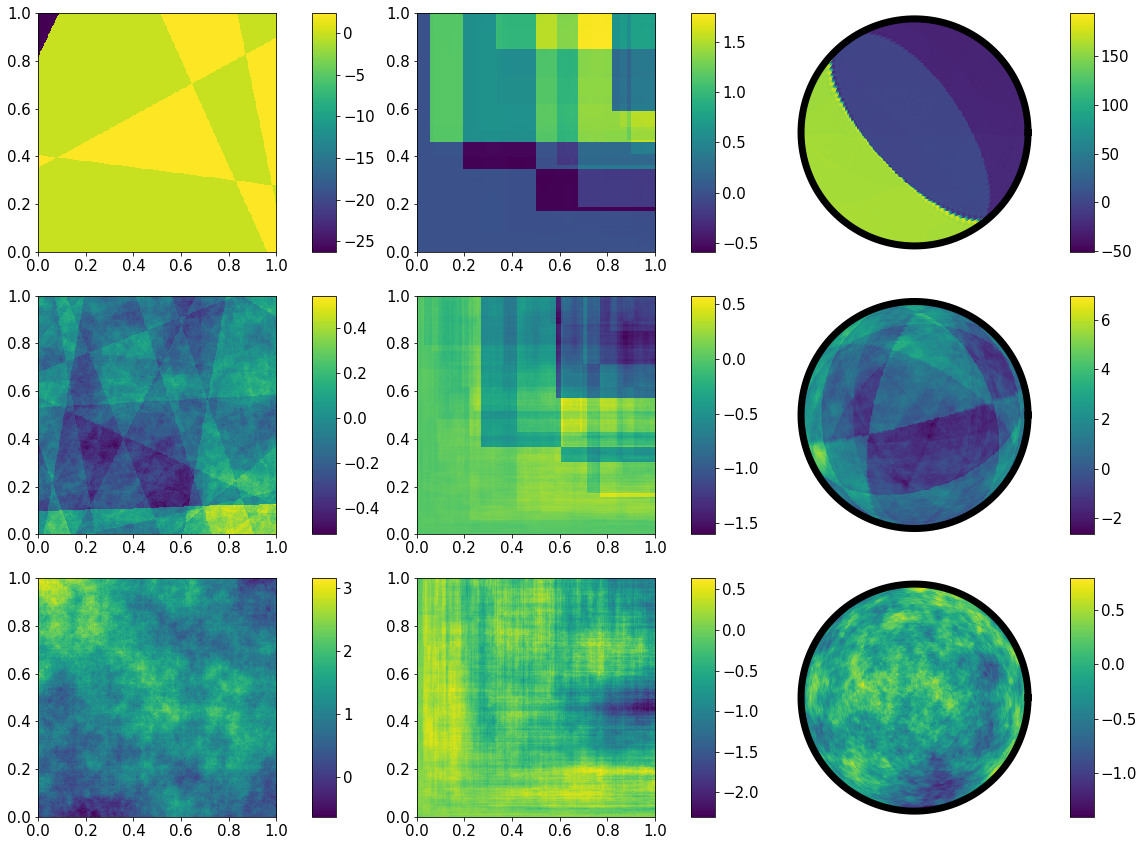

In [203]:
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

m = 300
n = 150

nn = 300
sph_vec = Sph_vec_coordinates(m, n)
x, y, z = Sph_cart_coordinates(sph_vec)

xi1, yi1, zi1 = polar2hemisphere(nn, Y_Sph1, sph_vec)
xi2, yi2, zi2 = polar2hemisphere(nn, Y_Sph2, sph_vec)
xi3, yi3, zi3 = polar2hemisphere(nn, Y_Sph3, sph_vec)

TT = np.linspace(0,2*np.pi,300)
XX,YY = np.cos(TT),np.sin(TT)


fig, axs = plt.subplots(3, 3, figsize=(16, 12), sharey=False)
plt.rc('font', size=15)
#plt.subplots_adjust(wspace = 0.0)


im1 = axs[0,0].imshow(Y_LC1, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])
divider1 = make_axes_locatable(axs[0,0])
cax1 = divider1.append_axes("right", size="10%", pad = 0.5)
#cax1 = fig.add_axes([axs[0,0].get_position().x1+0.01,axs[0,0].get_position().y0,0.02,axs[0,0].get_position().height])
plt.colorbar(im1, cax=cax1)
axs[0,0].set_ylim(bottom = 0, top = 1)
axs[0,0].set_xlim(left = 0, right = 1)

im2 = axs[1,0].imshow(Y_LC2, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])
divider2 = make_axes_locatable(axs[1,0])
cax2 = divider2.append_axes("right", size="10%", pad = 0.5)
#cax2 = fig.add_axes([axs[1,0].get_position().x1+0.01,axs[1,0].get_position().y0,0.02,axs[1,0].get_position().height])
plt.colorbar(im2,cax=cax2)
axs[1,0].set_ylim(bottom = 0, top = 1)
axs[1,0].set_xlim(left = 0, right = 1)

im3 = axs[2,0].imshow(Y_LC3, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])
divider3 = make_axes_locatable(axs[2,0])
cax3 = divider3.append_axes("right", size="10%", pad = 0.5)
#cax3 = fig.add_axes([axs[2,0].get_position().x1+0.01,axs[2,0].get_position().y0,0.02,axs[2,0].get_position().height])
plt.colorbar(im3,cax=cax3)
axs[2,0].set_ylim(bottom = 0, top = 1)
axs[2,0].set_xlim(left = 0, right = 1)

im4 = axs[0,1].imshow(Y_Mul1, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])
divider4 = make_axes_locatable(axs[0,1])
cax4 = divider4.append_axes("right", size="10%", pad = 0.5)
#cax4 = fig.add_axes([axs[0,1].get_position().x1+0.01,axs[0,1].get_position().y0,0.02,axs[0,1].get_position().height])
plt.colorbar(im4,cax=cax4)
axs[0,1].set_ylim(bottom = 0, top = 1)
axs[0,1].set_xlim(left = 0, right = 1)

im5 = axs[1,1].imshow(Y_Mul2, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])
divider5 = make_axes_locatable(axs[1,1])
cax5 = divider5.append_axes("right", size="10%", pad = 0.5)
#cax5 = fig.add_axes([axs[1,1].get_position().x1+0.01,axs[1,1].get_position().y0,0.02,axs[1,1].get_position().height])
plt.colorbar(im5,cax=cax5)
axs[1,1].set_ylim(bottom = 0, top = 1)
axs[1,1].set_xlim(left = 0, right = 1)

im6 = axs[2,1].imshow(Y_Mul3, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])
divider6 = make_axes_locatable(axs[2,1])
cax6 = divider6.append_axes("right", size="10%", pad = 0.5)
#cax6 = fig.add_axes([axs[2,1].get_position().x1+0.01,axs[2,1].get_position().y0,0.02,axs[2,1].get_position().height])
plt.colorbar(im6,cax=cax6)
axs[2,1].set_ylim(bottom = 0, top = 1)
axs[2,1].set_xlim(left = 0, right = 1)


im7 = axs[0,2].pcolormesh(xi1,yi1,zi1,cmap = "viridis",rasterized=True)
axs[0,2].plot(XX,YY,color = "black", linewidth = 7)
divider7 = make_axes_locatable(axs[0,2])
cax7 = divider7.append_axes("right", size="10%", pad=0.5)
#cax7 = fig.add_axes([axs[0,2].get_position().x1+0.01,axs[0,2].get_position().y0,0.02,axs[0,2].get_position().height])
plt.colorbar(im7,cax=cax7)
axs[0,2].axis('off')
axs[0,2].set_xlim([-1.05, 1.05])
axs[0,2].set_ylim([-1.05, 1.05])
#axs[0].set_title(r"$\alpha$=0.5" + r", $\beta$=0.8")
axs[0,2].set_aspect('equal')


im8 = axs[1,2].pcolormesh(xi2,yi2,zi2,cmap = "viridis",rasterized=True)
axs[1,2].plot(XX,YY,color = "black", linewidth = 7)
divider8 = make_axes_locatable(axs[1,2])
cax8 = divider8.append_axes("right", size="10%", pad=0.5)
#cax8 = fig.add_axes([axs[1,2].get_position().x1+0.01,axs[1,2].get_position().y0,0.02,axs[1,2].get_position().height])
plt.colorbar(im8, cax=cax8)
axs[1,2].axis('off')
axs[1,2].set_xlim([-1.05, 1.05])
axs[1,2].set_ylim([-1.05, 1.05])
#axs[1].set_title(r"$\alpha$=1.2" + r", $\beta$=0.8")
axs[1,2].set_aspect('equal')


im9 = axs[2,2].pcolormesh(xi3,yi3,zi3,cmap = "viridis",rasterized=True)
axs[2,2].plot(XX,YY,color = "black", linewidth = 7)
divider9 = make_axes_locatable(axs[2,2])
cax9 = divider9.append_axes("right", size="10%", pad=0.5)
#cax9 = fig.add_axes([axs[2,2].get_position().x1+0.01,axs[2,2].get_position().y0,0.02,axs[2,2].get_position().height])
plt.colorbar(im9,cax=cax9)
axs[2,2].axis('off')
axs[2,2].set_xlim([-1.05, 1.05])
axs[2,2].set_ylim([-1.05, 1.05])
#axs[2].set_title(r"$\alpha$=2" + r", $\beta$=0.8")
axs[2,2].set_aspect('equal')

fig.tight_layout()
plt.savefig('figure1.pdf', bbox_inches = 'tight')

plt.show()

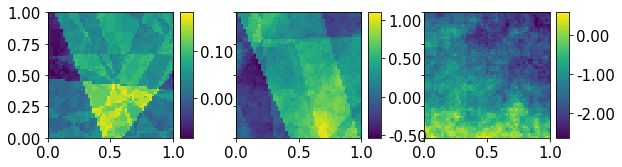

In [85]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
#plt.rc('font', size=15)
plt.subplots_adjust(wspace = 0.5)
im1 = axs[0].imshow(Y_LC1, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])
cax1 = fig.add_axes([axs[0].get_position().x1+0.01,axs[0].get_position().y0,0.02,axs[0].get_position().height])
plt.colorbar(im1, cax=cax1,format='%.2f')
axs[0].set_ylim(bottom = 0, top = 1)
axs[0].set_xlim(left = 0, right = 1)

im2 = axs[1].imshow(Y_LC2, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])
cax2 = fig.add_axes([axs[1].get_position().x1+0.01,axs[1].get_position().y0,0.02,axs[1].get_position().height])
plt.colorbar(im2,cax=cax2,format='%.2f')
axs[1].set_ylim(bottom = 0, top = 1)
axs[1].set_xlim(left = 0, right = 1)

im3 = axs[2].imshow(Y_LC3, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])
cax3 = fig.add_axes([axs[2].get_position().x1+0.01,axs[2].get_position().y0,0.02,axs[2].get_position().height])
plt.colorbar(im3,cax=cax3,format='%.2f')
axs[2].set_ylim(bottom = 0, top = 1)
axs[2].set_xlim(left = 0, right = 1)

plt.savefig('figure1_fLC.pdf', bbox_inches = 'tight')

plt.show()

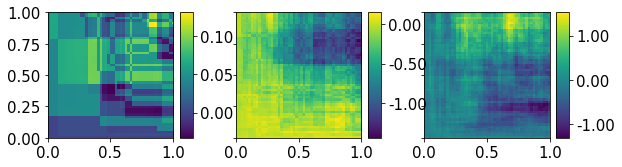

In [84]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
#plt.rc('font', size=15)
plt.subplots_adjust(wspace = 0.5)

im4 = axs[0].imshow(Y_Mul1, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])
cax4 = fig.add_axes([axs[0].get_position().x1+0.01,axs[0].get_position().y0,0.02,axs[0].get_position().height])
plt.colorbar(im4,cax=cax4,format='%.2f')
axs[0].set_ylim(bottom = 0, top = 1)
axs[0].set_xlim(left = 0, right = 1)

im5 = axs[1].imshow(Y_Mul2, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])
cax5 = fig.add_axes([axs[1].get_position().x1+0.01,axs[1].get_position().y0,0.02,axs[1].get_position().height])
plt.colorbar(im5,cax=cax5,format='%.2f')
axs[1].set_ylim(bottom = 0, top = 1)
axs[1].set_xlim(left = 0, right = 1)

im6 = axs[2].imshow(Y_Mul3, cmap='viridis', interpolation='nearest', origin='lower',extent = [0,1,0,1])
cax6 = fig.add_axes([axs[2].get_position().x1+0.01,axs[2].get_position().y0,0.02,axs[2].get_position().height])
plt.colorbar(im6,cax=cax6,format='%.2f')
axs[2].set_ylim(bottom = 0, top = 1)
axs[2].set_xlim(left = 0, right = 1)

plt.savefig('figure1_Multi.pdf', bbox_inches = 'tight')

plt.show()

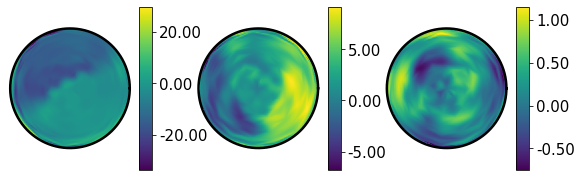

In [83]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

nn = 300
sph_vec = Sph_vec_coordinates(m, n)
x, y, z = Sph_cart_coordinates(sph_vec)

xi1, yi1, zi1 = polar2hemisphere(nn, Y_Sph1, sph_vec)
xi2, yi2, zi2 = polar2hemisphere(nn, Y_Sph2, sph_vec)
xi3, yi3, zi3 = polar2hemisphere(nn, Y_Sph3, sph_vec)

TT = np.linspace(0,2*np.pi,300)
XX,YY = np.cos(TT),np.sin(TT)

fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
#plt.rc('font', size=15)
plt.subplots_adjust(wspace = 0.5)


im7 = axs[0].pcolormesh(xi1,yi1,zi1,cmap = "viridis",rasterized=True)
axs[0].plot(XX,YY,color = "black", linewidth = 2.5)
cax7 = fig.add_axes([axs[0].get_position().x1+0.01,axs[0].get_position().y0,0.02,axs[0].get_position().height])
#divider0 = make_axes_locatable(axs[0])
#cax7 = divider0.append_axes("right", size="10%")
plt.colorbar(im7,cax=cax7,format='%.2f')
axs[0].axis('off')
axs[0].set_xlim([-1.05, 1.05])
axs[0].set_ylim([-1.05, 1.05])
#axs[0].set_title(r"$\alpha$=0.5" + r", $\beta$=0.8")
axs[0].set_aspect('equal')


im8 = axs[1].pcolormesh(xi2,yi2,zi2,cmap = "viridis",rasterized=True)
axs[1].plot(XX,YY,color = "black", linewidth = 2.5)
cax8 = fig.add_axes([axs[1].get_position().x1+0.01,axs[1].get_position().y0,0.02,axs[1].get_position().height])
#divider1 = make_axes_locatable(axs[1])
#cax8 = divider1.append_axes("right", size="10%")
plt.colorbar(im8, cax=cax8,format='%.2f')
axs[1].axis('off')
axs[1].set_xlim([-1.05, 1.05])
axs[1].set_ylim([-1.05, 1.05])
#axs[1].set_title(r"$\alpha$=1.2" + r", $\beta$=0.8")
axs[1].set_aspect('equal')


im9 = axs[2].pcolormesh(xi3,yi3,zi3,cmap = "viridis",rasterized=True)
axs[2].plot(XX,YY,color = "black", linewidth = 2.5)
cax9 = fig.add_axes([axs[2].get_position().x1+0.01,axs[2].get_position().y0,0.02,axs[2].get_position().height])
#divider2 = make_axes_locatable(axs[2])
#cax9 = divider2.append_axes("right", size="10%")
plt.colorbar(im9,cax=cax9,format='%.2f')
axs[2].axis('off')
axs[2].set_xlim([-1.05, 1.05])
axs[2].set_ylim([-1.05, 1.05])
#axs[2].set_title(r"$\alpha$=2" + r", $\beta$=0.8")
axs[2].set_aspect('equal')


plt.savefig('figure1_sfLC.pdf', bbox_inches = 'tight')

plt.show()


In [57]:
## spherical fractional Levy-Chentsov stable fields 
m = 300
n = 150

beta = 0.2
## alpha=2(Gaussian)
Y_Sph1 = Sph_fBm(m, n, beta/2)[0]

beta = 1
## alpha=2(Gaussian)
Y_Sph2 = Sph_fBm(m, n, beta/2)[0]

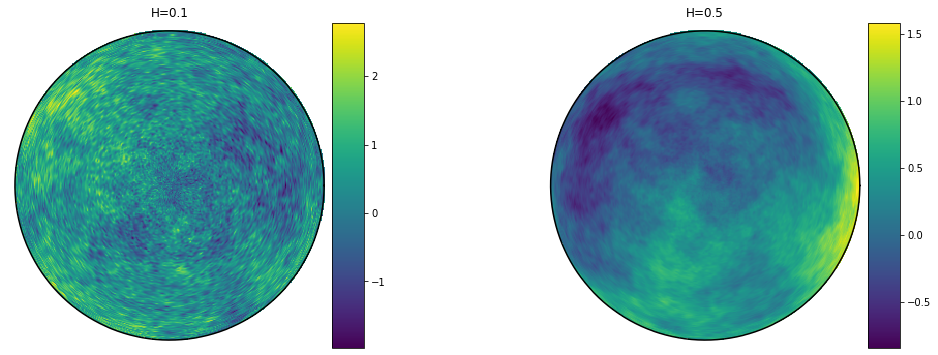

In [59]:
nn = 300
sph_vec = Sph_vec_coordinates(m, n)
x, y, z = Sph_cart_coordinates(sph_vec)

xi1, yi1, zi1 = polar2hemisphere(nn, Y_Sph1, sph_vec)
xi2, yi2, zi2 = polar2hemisphere(nn, Y_Sph2, sph_vec)

TT = np.linspace(0,2*np.pi,300)
XX,YY = np.cos(TT),np.sin(TT)

fig, axs = plt.subplots(1, 2, figsize=(16, 9), sharey=True)
#plt.rc('font', size=15)
plt.subplots_adjust(wspace = 0.5)

im7 = axs[0].pcolormesh(xi1,yi1,zi1,cmap = "viridis", rasterized=True)
axs[0].plot(XX,YY,color = "black")
#cax7 = fig.add_axes([axs[0].get_position().x1+0.01,axs[0].get_position().y0,0.02,axs[0].get_position().height])
divider1 = make_axes_locatable(axs[0])
cax7 = divider1.append_axes("right", size="10%")
plt.colorbar(im7,cax=cax7)
axs[0].axis('off')
axs[0].set_title('H=0.1')
axs[0].set_xlim([-1.05, 1.05])
axs[0].set_ylim([-1.05, 1.05])
axs[0].set_aspect('equal')


im8 = axs[1].pcolormesh(xi2,yi2,zi2,cmap = "viridis", rasterized=True)
axs[1].plot(XX,YY,color = "black")
#cax8 = fig.add_axes([axs[1].get_position().x1+0.01,axs[1].get_position().y0,0.02,axs[1].get_position().height])
divider2 = make_axes_locatable(axs[1])
cax8 = divider2.append_axes("right", size="10%")
plt.colorbar(im8, cax=cax8)
axs[1].axis('off')
axs[1].set_title('H=0.5')
axs[1].set_xlim([-1.05, 1.05])
axs[1].set_ylim([-1.05, 1.05])
axs[1].set_aspect('equal')


plt.savefig('sfBf.pdf')

plt.show()


## Figure 2

In [10]:
## comparison mean of \alpha, N_{\alpha,\epsilon}, \sigma_\alpha(\epsilon)
def R1_common_params(n, alpha):
    t = np.linspace(0, 1, n+1)
    if alpha == 1:
        C_alpha = np.pi/2
    else:
        C_alpha = (1-alpha)/(gamma(2-alpha)*np.cos(np.pi*alpha/2))
    epsilon = (0.01*(3-alpha)*np.sqrt(alpha*C_alpha)/((2-alpha)**(3/2)))**(2/alpha)     # error from B-E < 0.01
    sigma_epsilon = (np.sqrt(alpha*C_alpha/(2-alpha))**(1/2))*epsilon**(1-alpha/2)
    return t, epsilon, C_alpha, sigma_epsilon

m = 99

A = np.linspace(.1,2,m, endpoint = False)
epsilon = np.zeros(m)
C_alpha = np.zeros(m)
sigma_epsilon = np.zeros(m)
nu_epsi = np.zeros(m)
for i in range(0,m):
    t,epsilon[i],C_alpha[i],sigma_epsilon[i] = R1_common_params(1000,A[i])
    nu_epsi[i] = C_alpha[i]/(epsilon[i]**(A[i]))

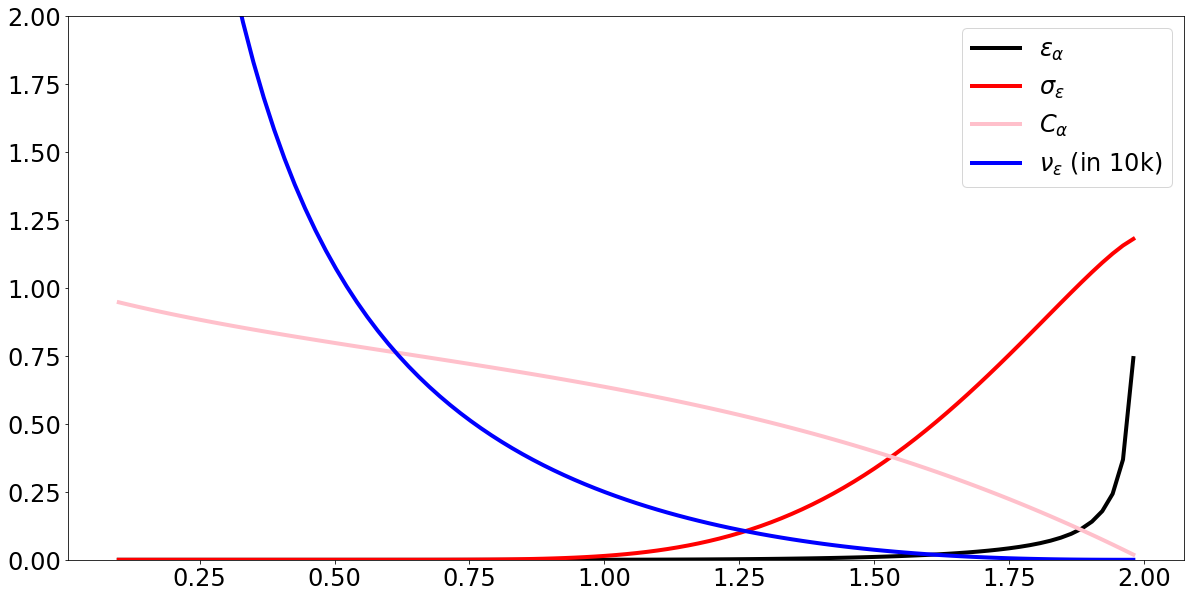

In [15]:
plt.figure(figsize = (20, 10))
plt.plot(A,epsilon,'-', color = 'black', label = r'$\epsilon_{\alpha}$', linewidth = 4)
plt.plot(A,sigma_epsilon,'-',color = 'red', label = r'$\sigma_{\epsilon}$',linewidth = 4)
plt.plot(A,C_alpha,'-',color = 'pink', label = r'$C_{\alpha}$',linewidth = 4)
plt.plot(A,nu_epsi/10000,'-',color = 'blue', label = r'$\nu_{\epsilon}$ (in 10k)',linewidth = 4)
plt.legend(loc = 'upper right', prop={'size': 24})
plt.ylim(0,2)
##plt.xlabel("Time")
plt.xlabel("")
plt.ylabel("")
plt.rc('font', size=24)
#plt.title("α=" + str(alpha) + " β=" + str(beta))
plt.savefig('figure2_parameters.pdf',bbox_inches = 'tight')
plt.show()

## Figure 3

In [8]:
def R1_oov_sampling(n, Lambda):
    t = np.linspace(0, 1, n+1)
    uu = np.random.uniform(0, 1)
    ind1 = np.where(t<uu, 0, 1)
    proba = 0.5*(1-np.exp(-2*(1/n)*Lambda))
    ind2 = np.random.binomial(1, proba, n+1)
    return (ind1+ind2.cumsum()) % 2

n = 1000

t = np.linspace(0, 1, n+1)
R1_oov1 = R1_oov_sampling(n, Lambda=5)
R1_oov2 = R1_oov_sampling(n, Lambda=10)
R1_oov3 = R1_oov_sampling(n, Lambda=50)

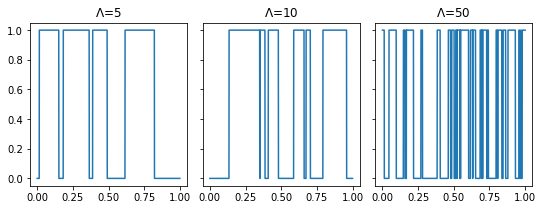

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
#plt.rc('font', size=15)
plt.subplots_adjust(wspace = 0.1)

axs[0].plot(t, R1_oov1)
#axs[0].set_xlabel("Time")
axs[0].set_title(r"$\Lambda$=5")

axs[1].plot(t, R1_oov2)
#axs[1].set_xlabel("Time")
axs[1].set_title(r"$\Lambda$=10")

axs[2].plot(t, R1_oov3)
#axs[2].set_xlabel("Time")
axs[2].set_title(r"$\Lambda$=50")

plt.savefig('figure3_KSP_OOV.pdf',bbox_inches = 'tight')

plt.show()


## Figure 5

In [10]:
def two_end_pts(r,theta,R):
    ## x = R, -R
    y1 = r/np.sin(theta) - 1/np.tan(theta)*R
    y2 = r/np.sin(theta) - 1/np.tan(theta)*(-R)
    ## y = R, -R
    x1 = (r/np.sin(theta)-R)*np.tan(theta)
    x2 = (r/np.sin(theta)+R)*np.tan(theta)
    
    X = np.array([R,-R,x1,x2])
    Y = np.array([y1,y2,R,-R])
    
    ind = np.where(X**2+Y**2<= 2* R**2)
    return X[ind],Y[ind]

def multi_oov_sampling(n, Lambda):
    t1, t2 = np.linspace(0, 1, n+1), np.linspace(0, 1, n+1)
    t_1, t_2 = np.meshgrid(t1, t2)
    u_x, u_y = np.random.uniform(0, 1, 1), np.random.uniform(0, 1, 1)
    ind1 = np.where((u_x < t_1) & (u_y < t_2), 1, 0)
    proba = 0.5*(1-np.exp(-(2/n**2)*Lambda))
    inddd = np.random.binomial(1, proba, (n+1)**2).reshape(n+1, n+1)
    ind2 = inddd.cumsum(axis = 0).cumsum(axis = 1)
    return (ind1 + ind2) % 2

def Levy_oov_sampling(n, Q):
    t1, t2 = np.linspace(0, 1, n+1), np.linspace(0, 1, n+1)
    t_1, t_2 = np.meshgrid(t1, t2)
    r = np.random.uniform(0, np.sqrt(2), Q)
    theta = np.random.uniform(0, 2*np.pi, Q)
    s_pos = np.c_[np.cos(theta), np.sin(theta)]
    count = np.zeros((n+1, n+1))
    for i in range(0, Q):
        event = np.where(r[i] < s_pos[i,0]*t_1+s_pos[i,1]*t_2, 1, 0)
        count += event
    return count % 2, r, theta

def Sph_coordinates_new(n):
    #theta = np.arccos(np.linspace(-1, 1, n+1))
    theta = (np.linspace(0, np.pi, n))
    phi = np.linspace(0, 2*np.pi, n,endpoint=False)
    theta,phi = np.meshgrid(theta,phi)
    theta,phi = theta.flatten(),phi.flatten()
    
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)
    return x, y, z, theta, phi

def Sph_random_coordinates(n):
    theta1 = np.random.uniform(0, 2*np.pi, n)
    u = np.random.uniform(-1, 1, n)
    theta2 = np.arccos(u)
    xx = np.sin(theta2)*np.cos(theta1)
    yy = np.sin(theta2)*np.sin(theta1)
    zz = np.cos(theta2)
    return xx, yy, zz

def Sph_counting(XX,YY,ZZ,X,Y,Z):
    count = np.sum((np.outer(X,XX) + np.outer(Y,YY) + np.outer(Z,ZZ)>0), axis = 1)
    return count % 2

def Spherical_oov_sampling(m, n, Q):
    Sph_vec = Sph_vec_coordinates(m, n)
    x, y, z = Sph_cart_coordinates(Sph_vec)
    xx, yy, zz = Sph_random_coordinates(Q)
    count1 = Sph_counting(xx,yy,zz,x,y,z)
    #count2 = Sph_counting(np.zeros(len(xx)), np.zeros(len(yy)), zz, np.zeros(n**2), np.zeros(n**2), np.ones(n**2))[0]
    return count1, xx, yy, zz

In [11]:
n = 300

## Multiparameter-KSP OOV
multi_oov1 = multi_oov_sampling(n, Lambda=5)
multi_oov2 = multi_oov_sampling(n, Lambda=50)
multi_oov3 = multi_oov_sampling(n, Lambda=500)

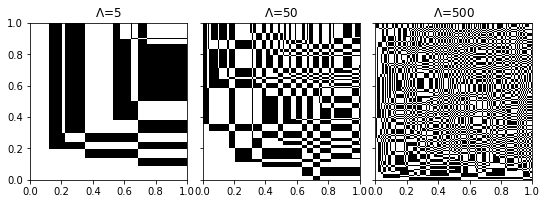

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
#plt.rc('font', size=15)
plt.subplots_adjust(wspace = 0.1)

axs[0].imshow(1-multi_oov1, cmap='gray', interpolation='nearest', origin='lower',extent = [0,1,0,1])
axs[0].set_title(r"$\Lambda$=5")
axs[1].imshow(1-multi_oov2, cmap='gray', interpolation='nearest', origin='lower',extent = [0,1,0,1])
axs[1].set_title(r"$\Lambda$=50")
axs[2].imshow(1-multi_oov3, cmap='gray', interpolation='nearest', origin='lower',extent = [0,1,0,1])
axs[2].set_title(r"$\Lambda$=500")

plt.savefig('figure5_Mul_OOV.pdf',bbox_inches = 'tight')

plt.show()


## Figure 7

In [13]:
n = 300

## Levy-KSP OOV
Levy_oov1, r1, theta1 = Levy_oov_sampling(n, Q=10)
Levy_oov2, r2, theta2 = Levy_oov_sampling(n, Q=100)
Levy_oov3, r3, theta3 = Levy_oov_sampling(n, Q=500)

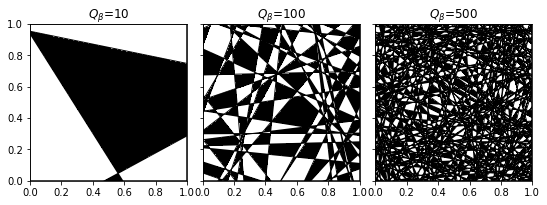

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
#plt.rc('font', size=15)
plt.subplots_adjust(wspace = 0.1)

axs[0].imshow(1-Levy_oov1, cmap='gray', interpolation='nearest', origin='lower',extent = [0,1,0,1])
axs[0].set_title(r"$Q_\beta$=10")
R1 = np.sqrt(2)
axs[0].set_ylim(bottom = 0,top = 1)
axs[0].set_xlim(left = 0, right = 1)

axs[0].plot((0,0),(0,1),color = 'black')
axs[0].plot((0,1),(1,1),color = 'black')
axs[0].plot((1,1),(1,0),color = 'black')
axs[0].plot((1,0),(0,0),color = 'black')
for i in range(0,10):
    X,Y = two_end_pts(r1[i], theta1[i], R1)
    axs[0].plot(X,Y,color = 'black', linewidth = 1)
    
axs[1].imshow(1-Levy_oov2, cmap='gray', interpolation='nearest', origin='lower',extent = [0,1,0,1])
axs[1].set_title(r"$Q_\beta$=100")
R2 = np.sqrt(2)
axs[1].set_ylim(bottom = 0, top = 1)
axs[1].set_xlim(left = 0, right = 1)

axs[1].plot((0,0),(0,1),color = 'black')
axs[1].plot((0,1),(1,1),color = 'black')
axs[1].plot((1,1),(1,0),color = 'black')
axs[1].plot((1,0),(0,0),color = 'black')
for i in range(0,100):
    X,Y = two_end_pts(r2[i], theta2[i], R2)
    axs[1].plot(X,Y,color = 'black', linewidth = 1)
    
axs[2].imshow(1-Levy_oov3, cmap='gray', interpolation='nearest', origin='lower',extent = [0,1,0,1])
axs[2].set_title(r"$Q_\beta$=500")
R3 = np.sqrt(2)
axs[2].set_ylim(bottom = 0,top = 1)
axs[2].set_xlim(left = 0, right = 1)

axs[2].plot((0,0),(0,1),color = 'black')
axs[2].plot((0,1),(1,1),color = 'black')
axs[2].plot((1,1),(1,0),color = 'black')
axs[2].plot((1,0),(0,0),color = 'black')
for i in range(0,500):
    X,Y = two_end_pts(r3[i], theta3[i], R3)
    axs[2].plot(X,Y,color = 'black', linewidth = 1)
    
plt.savefig('figure7_LC_OOV.pdf', bbox_inches = 'tight')

plt.show()

## Figure 8

In [15]:
m = 300
n = 150

## Spherical-KSP OOV
sph_oov1, xx1, yy1, zz1 = Spherical_oov_sampling(m, n, Q=5)
sph_oov2, xx2, yy2, zz2 = Spherical_oov_sampling(m, n, Q=10)
sph_oov3, xx3, yy3, zz3 = Spherical_oov_sampling(m, n, Q=50)

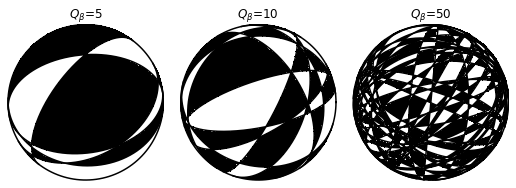

In [16]:
from matplotlib import colors

fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=False)
#plt.rc('font', size=15)
plt.subplots_adjust(wspace = 0.1)

nn = 300   
sph_vec = Sph_vec_coordinates(m, n)
#x, y, z, theta, phi = Sph_coordinates_new(n)
#sph_vec = np.zeros(len(x)*2).reshape(len(x),2)
#sph_vec[:,0], sph_vec[:,1] = theta, phi
x, y, z = Sph_cart_coordinates(sph_vec)
cart_vec = np.zeros(len(x)*3).reshape(len(x),3)
cart_vec[:,0] = x
cart_vec[:,1] = y
cart_vec[:,2] = z
bounds = [0,0.5,1]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
TT = np.linspace(0,2*np.pi,n)
XX,YY = np.cos(TT),np.sin(TT)

random_pts_cart1 = np.concatenate((xx1,yy1,zz1),axis = 0).reshape(3,5).transpose()
random_pts_sph1 = cart2sph_vec(random_pts_cart1)
xi1,yi1,zi1 = polar2hemisphere(nn,sph_oov1,sph_vec)
axs[0].pcolormesh(xi1,yi1,zi1,cmap = "gray", vmin = 0, vmax = 1, norm = norm, rasterized=True)
axs[0].plot(XX,YY,color = "black")
for i in range(5):
    GC_sph1 = great_circle_in_hemi(len(x),random_pts_sph1[i,:])
    GC_cart1 = sph2cart_vec(GC_sph1)
    axs[0].plot(GC_cart1[:,0],GC_cart1[:,1],color = "black")
axs[0].set_title(r"$Q_\beta$=5")
axs[0].set_xlim([-1.01, 1.01])
axs[0].set_ylim([-1.01, 1.01])
axs[0].axis('off')
axs[0].set_aspect('equal')


random_pts_cart2 = np.concatenate((xx2,yy2,zz2),axis = 0).reshape(3,10).transpose()
random_pts_sph2 = cart2sph_vec(random_pts_cart2)
xi2,yi2,zi2 = polar2hemisphere(nn,sph_oov2,sph_vec)
axs[1].pcolormesh(xi2,yi2,zi2,cmap = "gray", vmin = 0, vmax = 1, norm = norm, rasterized=True)
axs[1].plot(XX,YY,color = "black")
for i in range(10):
    GC_sph2 = great_circle_in_hemi(len(x),random_pts_sph2[i,:])
    GC_cart2 = sph2cart_vec(GC_sph2)
    axs[1].plot(GC_cart2[:,0],GC_cart2[:,1],color = "black")
axs[1].set_title(r"$Q_\beta$=10")
axs[1].set_xlim([-1.01, 1.01])
axs[1].set_ylim([-1.01, 1.01])
axs[1].axis('off')
axs[1].set_aspect('equal')


random_pts_cart3 = np.concatenate((xx3,yy3,zz3),axis = 0).reshape(3,50).transpose()
random_pts_sph3 = cart2sph_vec(random_pts_cart3)
xi3,yi3,zi3 = polar2hemisphere(nn,sph_oov3,sph_vec)
axs[2].pcolormesh(xi3,yi3,zi3,cmap = "gray", vmin = 0, vmax = 1, norm = norm, rasterized=True)
axs[2].plot(XX,YY,color = "black")
for i in range(50):
    GC_sph3 = great_circle_in_hemi(len(x),random_pts_sph3[i,:])
    GC_cart3 = sph2cart_vec(GC_sph3)
    axs[2].plot(GC_cart3[:,0],GC_cart3[:,1],color = "black")
axs[2].set_title(r"$Q_\beta$=50")
axs[2].set_xlim([-1.01, 1.01])
axs[2].set_ylim([-1.01, 1.01])
axs[2].axis('off')
axs[2].set_aspect('equal')

plt.savefig('figure9_sLC_OOV.pdf', bbox_inches = 'tight')

plt.show()

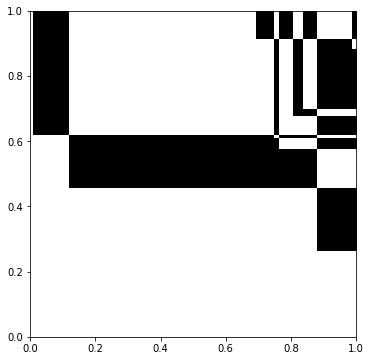

In [68]:
plt.figure(figsize=(6, 6))

plt.imshow(1-multi_oov1, cmap='gray', interpolation='nearest', origin='lower',extent = [0,1,0,1])
plt.show()



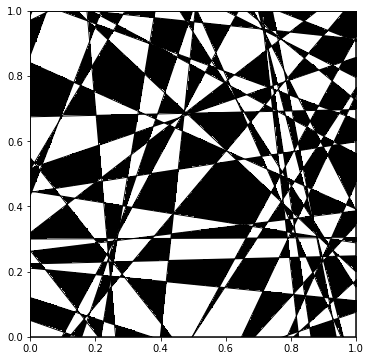

In [17]:
plt.figure(figsize=(6, 6))

plt.imshow(1-Levy_oov2, cmap='gray', interpolation='nearest', origin='lower',extent = [0,1,0,1])
R2 = np.sqrt(2)
plt.ylim(bottom = 0, top = 1)
plt.xlim(left = 0, right = 1)

plt.plot((0,0),(0,1),color = 'black')
plt.plot((0,1),(1,1),color = 'black')
plt.plot((1,1),(1,0),color = 'black')
plt.plot((1,0),(0,0),color = 'black')
for i in range(0,100):
    X,Y = two_end_pts(r2[i], theta2[i], R2)
    plt.plot(X,Y,color = 'black', linewidth = 1)

plt.savefig('OOV1.pdf',bbox_inches = 'tight')

plt.show()


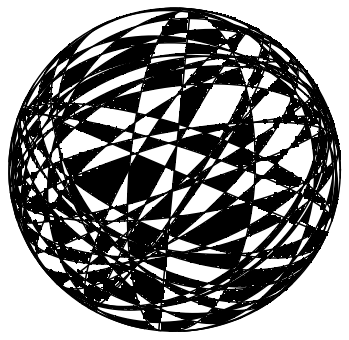

In [18]:
plt.figure(figsize=(6, 6))

plt.pcolormesh(xi3,yi3,zi3,cmap = "gray", vmin = 0, vmax = 1, norm = norm, rasterized=True)
plt.plot(XX,YY,color = "black")
for i in range(50):
    GC_sph3 = great_circle_in_hemi(len(x),random_pts_sph3[i,:])
    GC_cart3 = sph2cart_vec(GC_sph3)
    plt.plot(GC_cart3[:,0],GC_cart3[:,1],color = "black")
plt.xlim([-1.01, 1.01])
plt.ylim([-1.01, 1.01])
plt.axis('off')

plt.savefig('OOV2.pdf',bbox_inches = 'tight')

plt.show()